In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib notebook

# Get network informations

In [3]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [4]:
cluster_labels = pd.read_json('cluster_labels.json')
pressure_factor = pd.read_json('pressure_factor.json')
n_clusters = 30

Get results:

In [5]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [6]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [7]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


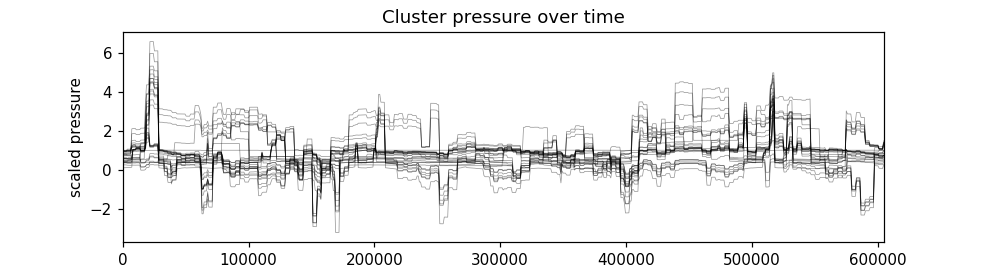

In [8]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('scaled pressure')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [9]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


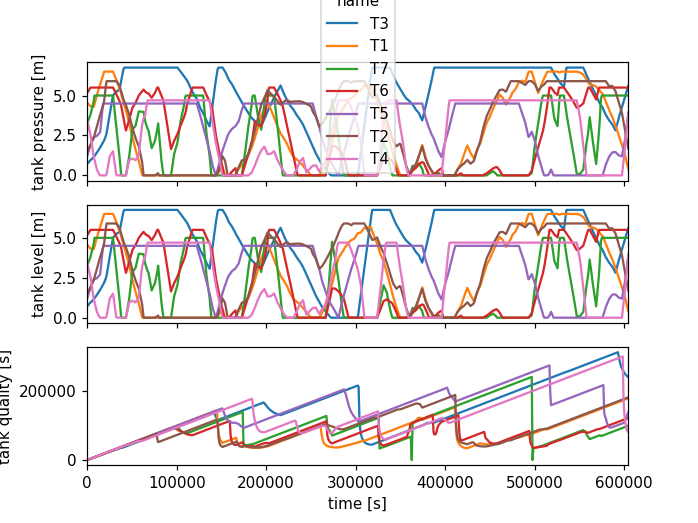

Text(0.5, 0, 'time [s]')

In [10]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [11]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


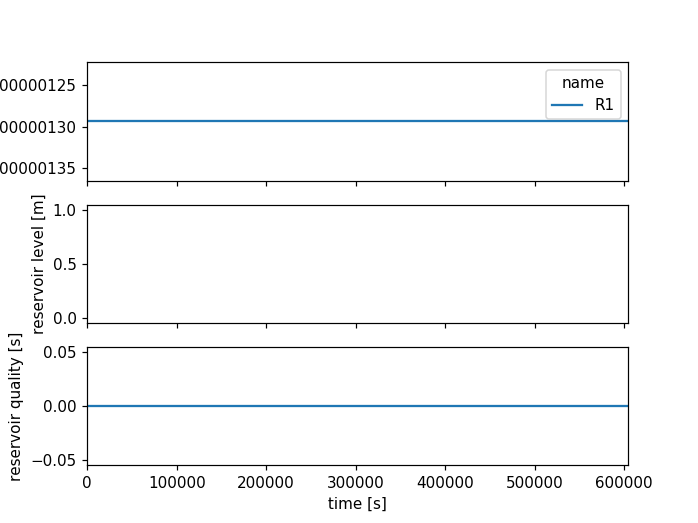

Text(0.5, 0, 'time [s]')

In [12]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [13]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


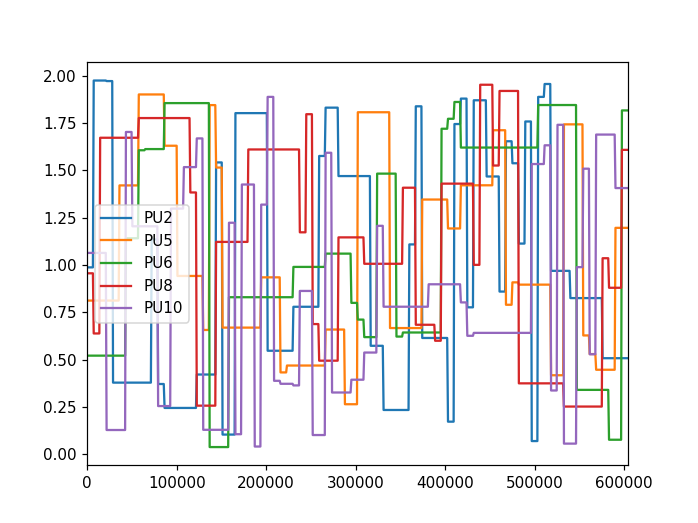

In [14]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

In [15]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,58.227444,14.631674,0.0,26.532584,23.435502
900,58.196094,14.636934,0.0,26.524227,23.469185
1800,58.165324,14.641828,0.0,26.515586,23.502525


<IPython.core.display.Javascript object>


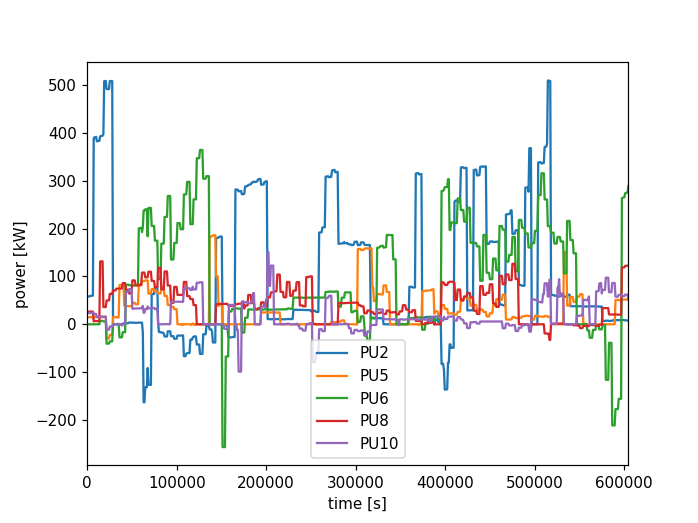

Text(0.5, 0, 'time [s]')

In [16]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [17]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


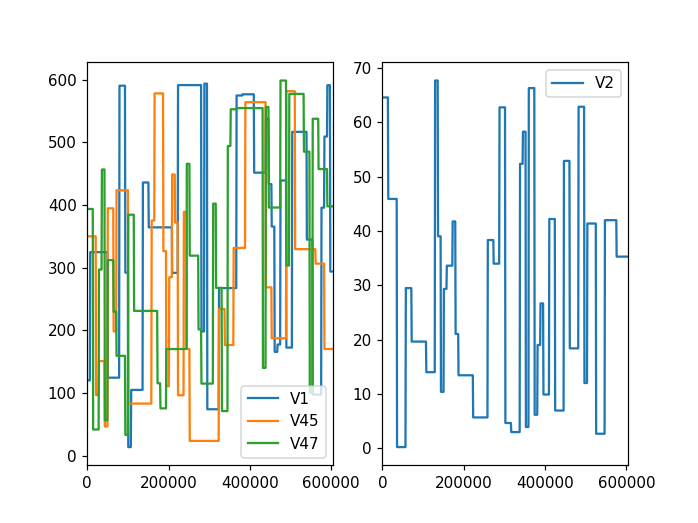

In [18]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [19]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [20]:
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs}


nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [21]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0             0.359735  0.942131  0.581662  0.945813  0.902581  0.492358   
900           0.358263  0.941637  0.582362  0.945172  0.901817  0.493456   
1800          0.356845  0.941151  0.583059  0.944541  0.901065  0.494547   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0     0.997837  0.254253  0.578518  0.488985  ...   3.397771  5.253158   
900   0.997174  0.252537  0.580050  0.489438  ...   3.534470  5.334502   
1800  0.996519  0.250848  0.581577  0.489889  ...   3.670313  5.415967   

                                   aux_outputs                             \
                                   pump_energy                              
            T5        T2        T4         PU2        PU5  PU6        PU8   
0     1.385392  1.612929  3.221158   58.227444  14.631674  0.0  26.532584   
900   1.550210  1.715537  2.992232   58.196094  14.636934  0.0  26.524227   
1800  1.714489  1.816875  2.763316   58.165324  14.641828  0.0  26.515586   

                 
                 
           PU10  
0     23.435502  
900   23.469185  
1800  23.502525  

[3 rows x 42 columns]

Inputs of the neural network:

In [22]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 76)


NARX model structure?

In [23]:
if True:
    n_arx = 20
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, keys=np.arange(n_arx), names=['NARX', 'type', 'name', 'index'], axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 1520)


In [24]:
nn_input.head(3)

NARX                 0                                                     \
type         sys_states                                                     
name  jun_cl_press_mean                                                     
index                0         1         2         3         4         5    
0              0.361217  0.942634  0.580960  0.946468  0.903360  0.491254   
900            0.359735  0.942131  0.581662  0.945813  0.902581  0.492358   
1800           0.358263  0.941637  0.582362  0.945172  0.901817  0.493456   

NARX                                           ...                19          \
type                                           ...        sys_inputs           
name                                           ... jun_cl_demand_sum           
index        6         7         8         9   ...                20  21  22   
0      0.998509  0.255970  0.576981  0.488532  ...               NaN NaN NaN   
900    0.997837  0.254253  0.578518  0.488985  ...               NaN NaN NaN   
1800   0.997174  0.252537  0.580050  0.489438  ...               NaN NaN NaN   

NARX                               
type                               
name                               
index  23  24  25  26  27  28  29  
0     NaN NaN NaN NaN NaN NaN NaN  
900   NaN NaN NaN NaN NaN NaN NaN  
1800  NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 1520 columns]

Check if NARX structure works:

In [25]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(5)

NARX,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
0,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1800,0.358263,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2700,0.356845,0.358263,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3600,0.329629,0.356845,0.358263,0.359735,0.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filter inputs and outputs:

In [26]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (653, 1520)


In [27]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(3)

NARX,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
17100,0.142595,0.141557,0.140517,0.139476,0.356994,0.357670,0.358347,0.359031,0.347524,0.348764,0.350054,0.351405,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263,0.359735,0.361217
18000,0.164150,0.142595,0.141557,0.140517,0.139476,0.356994,0.357670,0.358347,0.359031,0.347524,0.348764,0.350054,0.351405,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263,0.359735
18900,0.253972,0.164150,0.142595,0.141557,0.140517,0.139476,0.356994,0.357670,0.358347,0.359031,0.347524,0.348764,0.350054,0.351405,0.322979,0.325200,0.327420,0.329629,0.356845,0.358263


In [28]:
pd.DataFrame(nn_output['sys_states','jun_cl_press_mean',0]).head(3)

,sys_states
,jun_cl_press_mean
,0
17100,0.164150
18000,0.253972
18900,0.256446


### Compare to external output function:

This function is used to create the complete dataset for training.

In [29]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

nn_input_ext, nn_output_ext = get_data(file_list, narx_horizon=20)

In [30]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [31]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [33]:
X_train.shape

(522, 1520)

# Neural Network

## Create Model

In [34]:
n_layer = 3
n_units = 70
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1520)]            0         
_________________________________________________________________
dense (Dense)                (None, 70)                106470    
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_2 (Dense)              (None, 42)                2982      
Total params: 114,422
Trainable params: 114,422
Non-trainable params: 0
_________________________________________________________________


## Train model

In [35]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [36]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=50, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 522 samples, validate on 131 samples
Epoch 1/1000
522/522 [==============================] - 1s 2ms/sample - loss: 0.1555 - val_loss: 0.0871
Epoch 2/1000
522/522 [==============================] - 0s 356us/sample - loss: 0.0647 - val_loss: 0.0563
Epoch 3/1000
522/522 [==============================] - 0s 235us/sample - loss: 0.0421 - val_loss: 0.0438
Epoch 4/1000
522/522 [==============================] - 0s 228us/sample - loss: 0.0316 - val_loss: 0.0357
Epoch 5/1000
522/522 [==============================] - 0s 283us/sample - loss: 0.0250 - val_loss: 0.0306
Epoch 6/1000
522/522 [==============================] - 0s 305us/sample - loss: 0.0210 - val_loss: 0.0276
Epoch 7/1000
522/522 [==============================] - 0s 284us/sample - loss: 0.0184 - val_loss: 0.0256
Epoch 8/1000
522/522 [==============================] - 0s 348us/sample - loss: 0.0162 - val_loss: 0.0236
Epoch 9/1000
522/522 [==============================] - 0s 242us/sample - loss: 0.0147 - val_loss: 0.0220
Ep

522/522 [==============================] - 0s 271us/sample - loss: 0.0017 - val_loss: 0.0108
Epoch 78/1000
522/522 [==============================] - 0s 280us/sample - loss: 0.0017 - val_loss: 0.0110
Epoch 79/1000
522/522 [==============================] - 0s 291us/sample - loss: 0.0017 - val_loss: 0.0108
Epoch 80/1000
522/522 [==============================] - 0s 214us/sample - loss: 0.0017 - val_loss: 0.0108
Epoch 81/1000
522/522 [==============================] - 0s 306us/sample - loss: 0.0016 - val_loss: 0.0110
Epoch 82/1000
522/522 [==============================] - 0s 445us/sample - loss: 0.0017 - val_loss: 0.0107
Epoch 83/1000
522/522 [==============================] - 0s 339us/sample - loss: 0.0016 - val_loss: 0.0107
Epoch 84/1000
522/522 [==============================] - 0s 300us/sample - loss: 0.0016 - val_loss: 0.0108
Epoch 85/1000
522/522 [==============================] - 0s 381us/sample - loss: 0.0016 - val_loss: 0.0106
Epoch 86/1000
522/522 [============================

522/522 [==============================] - 0s 243us/sample - loss: 7.2888e-04 - val_loss: 0.0099
Epoch 153/1000
522/522 [==============================] - 0s 158us/sample - loss: 7.1805e-04 - val_loss: 0.0098
Epoch 154/1000
522/522 [==============================] - 0s 163us/sample - loss: 6.6524e-04 - val_loss: 0.0100
Epoch 155/1000
522/522 [==============================] - 0s 196us/sample - loss: 6.7530e-04 - val_loss: 0.0098
Epoch 156/1000
522/522 [==============================] - 0s 180us/sample - loss: 6.5337e-04 - val_loss: 0.0099
Epoch 157/1000
522/522 [==============================] - 0s 181us/sample - loss: 6.7761e-04 - val_loss: 0.0096
Epoch 158/1000
522/522 [==============================] - 0s 154us/sample - loss: 6.6663e-04 - val_loss: 0.0097
Epoch 159/1000
522/522 [==============================] - 0s 151us/sample - loss: 6.7101e-04 - val_loss: 0.0101
Epoch 160/1000
522/522 [==============================] - 0s 153us/sample - loss: 7.3612e-04 - val_loss: 0.0100
Epoch 1

522/522 [==============================] - 0s 224us/sample - loss: 5.3428e-04 - val_loss: 0.0090
Epoch 226/1000
522/522 [==============================] - 0s 309us/sample - loss: 5.3105e-04 - val_loss: 0.0094
Epoch 227/1000
522/522 [==============================] - 0s 303us/sample - loss: 5.6445e-04 - val_loss: 0.0095
Epoch 228/1000
522/522 [==============================] - 0s 162us/sample - loss: 5.9538e-04 - val_loss: 0.0092
Epoch 229/1000
522/522 [==============================] - 0s 158us/sample - loss: 6.3269e-04 - val_loss: 0.0096
Epoch 230/1000
522/522 [==============================] - 0s 153us/sample - loss: 7.0462e-04 - val_loss: 0.0094
Epoch 231/1000
522/522 [==============================] - 0s 151us/sample - loss: 5.9317e-04 - val_loss: 0.0093
Epoch 232/1000
522/522 [==============================] - 0s 153us/sample - loss: 4.8175e-04 - val_loss: 0.0093
Epoch 233/1000
522/522 [==============================] - 0s 167us/sample - loss: 4.6816e-04 - val_loss: 0.0094
Epoch 2

## Evaluate model

In [37]:
class narx_simulator:
    def __init__(self, model, n_arx, input_scaling, output_scaling, input_offset, output_offset, nn_in_0):
        self.model = model
        self.n_arx = n_arx
        
        self.input_scaling = input_scaling.to_numpy()
        self.output_scaling = output_scaling.to_numpy()
        self.input_offset = input_offset.to_numpy()
        self.output_offset = output_offset.to_numpy()
        
        self.nn_in = nn_in_0
        
        self.t0 = nn_in_0.index[0]
        self.dt = 900
        
    def prepare_next_iter(self):  
        # Update time
        t_prev = self.t0
        self.t0 += self.dt
        # Create new row in results table:
        self.nn_in.append(pd.Series(name=self.t0))
        # Update current states:
        #self.nn_in.loc[self.t0,(0,'sys_states')] = self.next_state.loc[t_prev].to_numpy()
        self.nn_in.loc[self.t0,(0,'sys_states')] = self.nn_out_df['sys_states'].to_numpy().flatten()


        # Update previous states + inputs for NARX structure
        for k in range(self.n_arx-1):
            self.nn_in.loc[self.t0,(k+1,'sys_states')] = self.nn_in.loc[t_prev,(k,'sys_states')].to_numpy()        
            self.nn_in.loc[self.t0,(k+1,'sys_inputs')] = self.nn_in.loc[t_prev,(k,'sys_inputs')].to_numpy()
        
    def eval_nn(self):
        # Scale input:
        nn_in_scaled = (self.nn_in.tail(1)-self.input_offset)/self.input_scaling
        # Evaluate NN:
        nn_out_scaled = self.model.predict(nn_in_scaled.to_numpy())
        # Scale output:
        nn_out = nn_out_scaled*self.output_scaling+self.output_offset
        
        self.nn_out_df = pd.DataFrame(nn_out, columns=nn_output.keys())
        # Output is difference from current to next state. Calculate next state:
#         self.next_state = self.nn_in[0,'sys_states'].tail(1) + nn_out
        self.next_state = nn_out
        
    def next_step(self, sys_inputs_now):
        self.nn_in.loc[self.t0,(0,'sys_inputs')] = sys_inputs_now.to_numpy()
        
        self.eval_nn()
        
        self.prepare_next_iter()
        

In [38]:
nsim = narx_simulator(model, 20, input_scaling, output_scaling, input_offset, output_offset, nn_input.head(1))

In [39]:
for k in range(50):
    sys_inputs_now = nn_input.loc[nsim.t0,(0,'sys_inputs')]
    nsim.next_step(sys_inputs_now)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


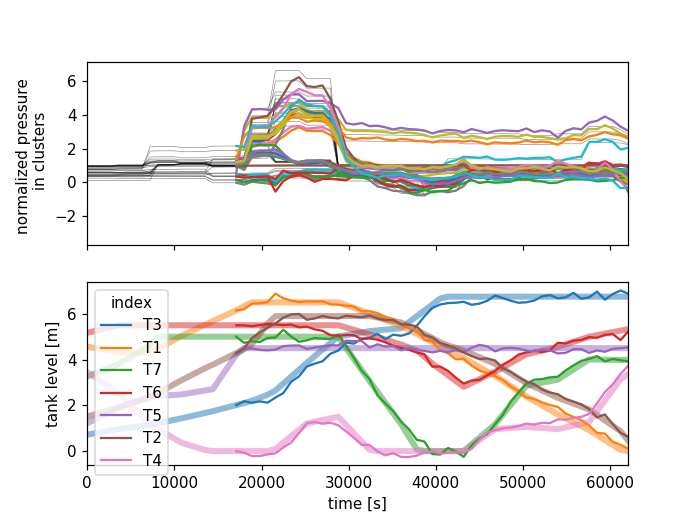

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning:

indexing past lexsort depth may impact performance.



Text(0.5, 0, 'time [s]')

In [40]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
nsim.nn_in[0,'sys_states', 'jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
nsim.nn_in[0,'sys_states', 'tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, nsim.nn_in.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [86]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
nsim_lin = narx_simulator(linear_reg, 20, input_scaling, output_scaling, input_offset, output_offset, nn_input.head(1))

In [90]:
for k in range(5):
    sys_inputs_now = nn_input.loc[nsim_lin.t0,(0,'sys_inputs')]
    nsim_lin.next_step(sys_inputs_now)

ValueError: setting an array element with a sequence.

<IPython.core.display.Javascript object>


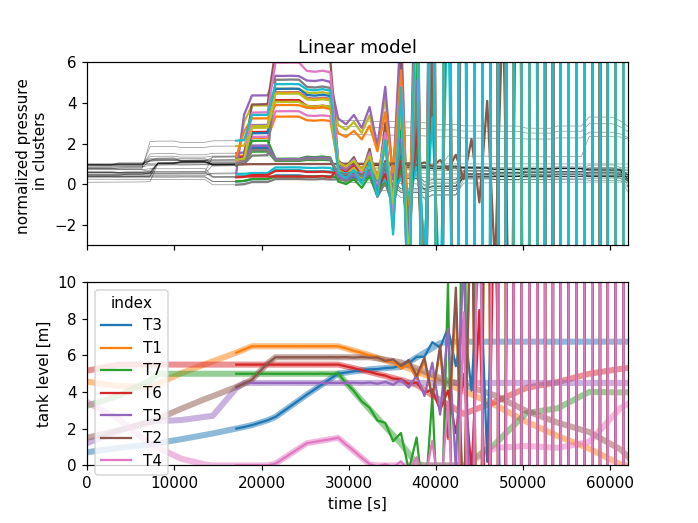

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning:

indexing past lexsort depth may impact performance.



(0, 10)

In [41]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
nsim_lin.nn_in[0,'sys_states', 'jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
nsim_lin.nn_in[0,'sys_states', 'tank_press'].plot(ax=ax[1])

ax[0].set_title('Linear model')
ax[0].set_xlim(0, nsim_lin.nn_in.index.max())
ax[0].set_ylim(-3, 6)

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

ax[1].set_ylim(0, 10)

# Create full training data set:

## Load data

In [48]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:10]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [49]:
nn_input, nn_output = get_data(file_list, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

## Save everything

Pack everything needed for training in a .pkl file:

In [ ]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('./training_data/training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [90]:
model_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/models/01_series/'
model_name = '030_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open(model_path+model_name+'_aux.pkl', 'rb') as f:
    model_param = pickle.load(f)

In [91]:
model_param.keys()
x_scaling = model_param['x_scaling']
y_scaling = model_param['y_scaling']
x_offset = model_param['x_offset']
y_offset = model_param['y_offset']

nsim = narx_simulator(model_ext, 6, x_scaling, y_scaling, x_offset, y_offset, nn_input.head(1))

In [92]:
for k in range(100):
    sys_inputs_now = nn_input.loc[nsim.t0,(0,'sys_inputs')]
    nsim.next_step(sys_inputs_now)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


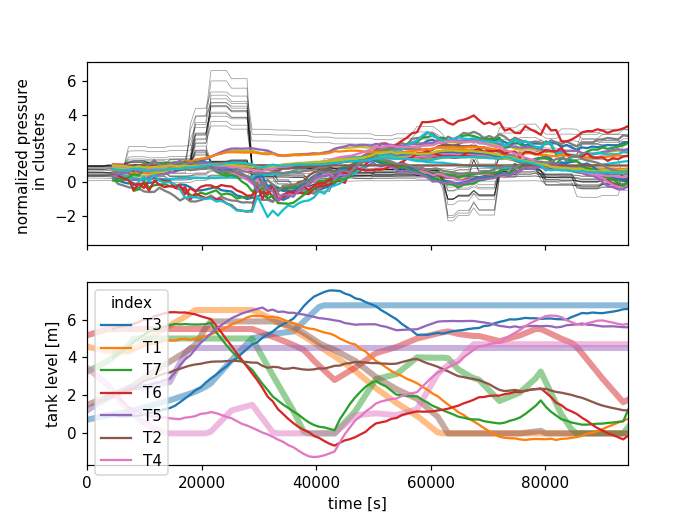

Text(0.5, 0, 'time [s]')

In [93]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
nsim.nn_in[0,'sys_states', 'jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
nsim.nn_in[0,'sys_states', 'tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, nsim.nn_in.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')